In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import lsim
from scipy.integrate import solve_ivp
import opentorsion as ot
import cvxpy as cp

# The propulsion system

Firstly, the propulsion system presented in [Inverse ice-induced moment determination on the propeller of an ice-going vessel](https://www.sciencedirect.com/science/article/pii/S0165232X14002274) is modelled using the openTorsion library. Parameters for the propulsion system are found from [here](https://journals.sagepub.com/doi/full/10.1177/14759217211004232).

In [2]:
def propulsion_system():
    J1 = 1.347e4 # propeller
    J3 = 5.590e2
    J5 = 5.120e2
    J7 = 4.870e2
    J9 = 1.410e2
    J11 = 1.740e2
    J13 = 4.415e3 # motor
    
    k2 = 5.88e7
    k4 = 5.95e7
    k6 = 1.12e8
    k8 = 6.93e8
    k10 = 5.09e8
    k12 = 1.43e8
    damping = 180 # damping in steel_shafts
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [3]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, C, K = assembly.M(), assembly.C(), assembly.K()  # Mass and stiffness matrices
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

In [4]:
k_list = [5.88e7, 5.95e7, 1.12e8, 6.93e8, 5.09e8, 1.43e8]

In [5]:
def X(k_values, ndof):
    """
    Used to transform the state-matrix to be compatible with shaft torque as a state.
    """
    rows = ndof-1
    cols = ndof
    if len(k_values) != rows:
        print("wrong amount of stiffness values / dofs")
        return
    
    X_up = np.zeros((rows, cols))
    X_down = np.eye(cols)
    Z_up = np.zeros(X_up.shape)
    Z_down = np.zeros(X_down.shape)
    
    for i in range(rows):
        X_up[i,i] = -k_values[i]
        X_up[i,i+1] = k_values[i]
    
    X_matrix = np.vstack([np.hstack([X_up, Z_up]), np.hstack([Z_down, X_down])])
    
    return X_matrix

### Construction of the extended observability matrix and the impulse response matrix used in the data equation.

In [6]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    O = np.copy(C)
    for k in range(1, n):
        O = np.vstack((O, C @ np.linalg.matrix_power(A, k)))

    return O

In [7]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    # first column
    gamma_column_first = np.zeros((C @ B).shape)
    for k in range(1, n):
        gamma_column_first = np.vstack((gamma_column_first, C @ np.linalg.matrix_power(A, k) @ B))

    # build complete matrix
    gamma = gamma_column_first
    current_col = 1
    for s in range(1, n):
        gamma_rows = np.zeros((C @ B).shape)
        for z in range(1, current_col):
            row_val = np.zeros((C @ B).shape)
            gamma_rows = np.vstack((gamma_rows, row_val))
        for nz in range(n-current_col):
            row_val = C @ np.linalg.matrix_power(A, nz) @ B
            gamma_rows = np.vstack((gamma_rows, row_val))

        gamma = np.hstack((gamma, gamma_rows))
        current_col += 1

    return gamma

### The regularization matrix

The regularization matrix $L$ as presented in the paper of Ikonen et al. (Note: In the paper, the external load of the propulsion system model is described in changes of moment between consecutive timesteps. Perhaps an identity matrix should be used here?)

In [8]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    meas_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return L

### Convex optimization problem

Here a Tikhonov-regularized optimization problem is defined using measurements from the propulsion system model, the data equation matrix $\Gamma$ and the regularization matrix $L$. For the present case, an optimal regularization parameter $\lambda = 0.0512$ is defined using the L-curve plot in the paper of Ikonen et al.

The python package [CVXPY](https://www.cvxpy.org/) provides an interface for the solver [MOSEK](https://www.mosek.com/), which is used to solve the Tikhonov-regularized optimization problem.

In [9]:
def convex_optimization_problem(meas, gamm, regu, lam=0.0512):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    d = cp.Variable((gamm.shape[1], 1))
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    # objective = cp.Minimize(cp.sum_squares(meas - O @ x - gamma @ d) + lam * cp.pnorm(L @ d, 1))
    objective = cp.Minimize(cp.sum_squares(measurements - gamm @ d) + lam * cp.sum_squares(regu @ d))
    prob = cp.Problem(objective)
    
    prob.solve(solver=cp.MOSEK, warm_start=True, verbose=False)

    return d.value

### Unit step response of the propulsion system

Here a unit step response is calculated for the propulsion system. The shaft torque between nodes 3 and 4 is plotted, as is in the paper of Ikonen et al.

In [10]:
assembly = propulsion_system()
ndof = assembly.dofs
A, B = state_matrices(assembly)
C = np.eye(B.shape[0])
D = np.zeros(B.shape)

# The state matrix, if shaft torque is a state instead of nodal angles
trans = X(k_list, ndof)
trans_inv = trans.T @ np.linalg.inv(trans @ trans.T)
A_transformed = trans @ A @ trans_inv
B_transformed = np.delete(B, (0), axis=0)
C_transformed = np.eye(B_transformed.shape[0])
D_transformed = np.zeros(B_transformed.shape)
print(A_transformed.shape)

Eigenfrequencies:  [  0.     0.    11.41  11.41  48.93  48.93  78.82  78.82 115.27 115.27
 268.61 268.61 522.81 522.81]
(13, 14)


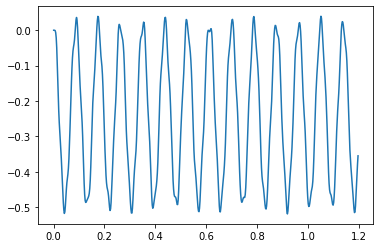

In [12]:
t = np.arange(0, 1.200, 0.002)

# impulse applied at node 0
u = np.zeros((len(t), 7))
u[:,0] = 1

tout, yout, xout = lsim((A, B, C, D), u, t)

plt.plot(tout, 6.93e8*(yout[:,4] - yout[:,3]))
plt.show()

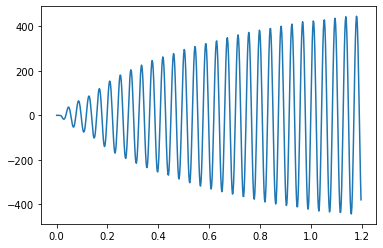

In [13]:
t = np.arange(0, 1.200, 0.002)

# impulse applied at node 0
u = np.zeros(ndof)
u[0] = 1

def f(t, x):
    return A @ x + B @ u

sol = solve_ivp(f, (t[0], t[-1]), np.zeros(2*ndof), t_eval=t)
plt.plot(sol.t, 6.93e8*(sol.y[4,:] - sol.y[3,:]))
plt.show()

### Generating measurement data

To avoid inverse crime, in the paper of Ikonen et al., the propulsion system model defined above is modified by varying the inertia and stiffness values by $\pm 10$% and adding an additional damping coefficient for the propeller.

In [14]:
def propulsion_system():
    J1 = np.random.uniform(0.9, 1.1)*1.347e4 # propeller
    J3 = np.random.uniform(0.9, 1.1)*5.590e2
    J5 = np.random.uniform(0.9, 1.1)*5.120e2
    J7 = np.random.uniform(0.9, 1.1)*4.870e2
    J9 = np.random.uniform(0.9, 1.1)*1.410e2
    J11 = np.random.uniform(0.9, 1.1)*1.740e2
    J13 = np.random.uniform(0.9, 1.1)*4.415e3 # motor
    
    k2 = np.random.uniform(0.9, 1.1)*5.88e7
    k4 = np.random.uniform(0.9, 1.1)*5.95e7
    k6 = np.random.uniform(0.9, 1.1)*1.12e8
    k8 = np.random.uniform(0.9, 1.1)*6.93e8 # this value is used in the calculation of the shaft torque and must be saved
    k10 = np.random.uniform(0.9, 1.1)*5.09e8
    k12 = np.random.uniform(0.9, 1.1)*1.43e8
    damping = 180 # damping in steel_shafts
    propeller_damping = 120e3 # the propeller damping
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1, c=propeller_damping))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly, k8

In [15]:
assembly, shaft8_stiffness = propulsion_system()
A, B = state_matrices(assembly)
C = np.eye(B.shape[0])
D = np.zeros(B.shape)

Eigenfrequencies:  [0.0000000e+00 9.5800000e+00 9.5800000e+00 4.7210000e+01 4.7210000e+01
 7.8100000e+01 7.8100000e+01 1.1327000e+02 1.1327000e+02 2.8028000e+02
 2.8028000e+02 5.3732000e+02 5.3732000e+02 1.8536165e+05]


(600,)


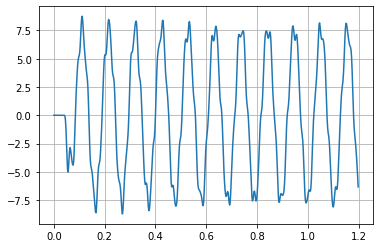

In [16]:
t = np.arange(0, 1.200, 0.002)
print(t.shape)

# impulse applied at node 0
u = np.zeros((len(t), 7))
u[20:40,0] = 200000

tout, yout, xout = lsim((A, B, C, D), u, t)

torque_meas = shaft8_stiffness*(yout[:,4]-yout[:,3])

plt.plot(tout, torque_meas)
plt.grid()
plt.show()

In [17]:
def construct_measurement(n, y):
    '''
    This function is used to construct a measurement vector used in the convex optimization
    problem so that for each timestep there is a vector containing one of each measurement.
    In this case, angle and speed measurements from nodes 3 and 4 are used (4 measurements per timestep in total). 
    '''
    measurement = np.vstack([y[0,0], y[0,1], y[0,2], y[0,3]])
    for i in range(1, n):
        measurement = np.vstack([measurement, y[i,0], y[i,1], y[i,2], y[i,3]])
    return measurement

Here an observation matrix is defined for measuring the angles and speeds at nodes 3 and 4. The convex optimization problem is solved using batches of measurements of 7 consecutive timesteps.

In [18]:
n = 7 # number of measurements in the batch
dofs = 7
estimates = np.zeros((n*dofs, 1))
idx = 0

obs = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

gam = gamma(A, B, obs, n)
reg = L(7*n) # size: number of nodes times number of timesteps
for i in range(int((yout.shape[0]-(yout.shape[0]%7))/n)):
    y = np.hstack([yout[idx:idx+n, 3:5], yout[idx:idx+n, 10:12]])
    idx += n
    meas_batch = construct_measurement(n, y)
    estimate = convex_optimization_problem(meas_batch, gam, reg, lam=1e-20)
    estimates = np.vstack([estimates, estimate])

(4214, 1)


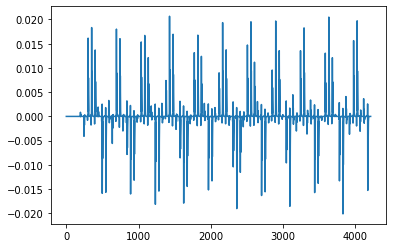

In [19]:
print(estimates.shape)
plt.plot(estimates)
plt.show()

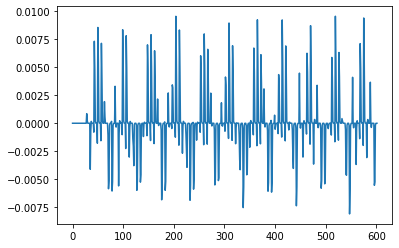

In [20]:
node0_estimates = estimates[0::7]
plt.plot(node0_estimates)
plt.show()